# 1. Loading and preprocessing

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# Create a list with the filepaths for training and testing
train_dir = Path(r"C:\Users\isaac\Desktop\Dataset\train")
train_filepaths = list(train_dir.glob(r'**\*.jpg'))
test_dir = Path(r"C:\Users\isaac\Desktop\Dataset\test")
test_filepaths = list(test_dir.glob(r'**\*.jpg'))

In [3]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

In [4]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 405

Number of different labels: 2

Labels: ['apple' 'cabbage']


In [5]:
train_df.head(5)

,Filepath,Label
0,C:\Users\isaac\Desktop\Dataset\train\apple\r0_...,apple
1,C:\Users\isaac\Desktop\Dataset\train\apple\r1_...,apple
2,C:\Users\isaac\Desktop\Dataset\train\apple\r1_...,apple
3,C:\Users\isaac\Desktop\Dataset\train\apple\r1_...,apple
4,C:\Users\isaac\Desktop\Dataset\train\apple\r1_...,apple


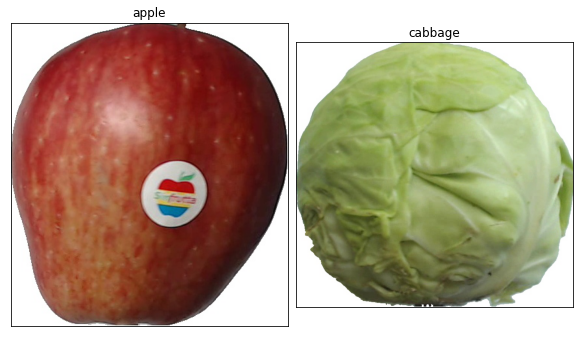

In [6]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# 2. Load the Images with a generator and Data Augmentation

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False)

Found 405 validated image filenames belonging to 2 classes.
Found 201 validated image filenames belonging to 2 classes.


In [8]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

# 3. Train the model

In [9]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    batch_size = 70,
    epochs=4,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/4
13/13 [==============================] - 10s 659ms/step - loss: 0.1375 - accuracy: 0.9383
Epoch 2/4
13/13 [==============================] - 8s 586ms/step - loss: 1.6965e-04 - accuracy: 1.0000
Epoch 3/4
13/13 [==============================] - 9s 695ms/step - loss: 1.7458e-05 - accuracy: 1.0000
Epoch 4/4
13/13 [==============================] - 8s 563ms/step - loss: 8.1725e-06 - accuracy: 1.0000


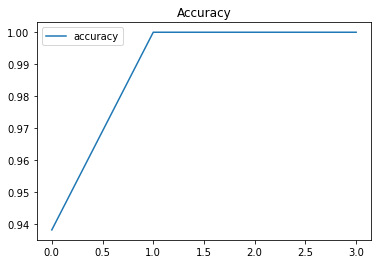

In [10]:
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()

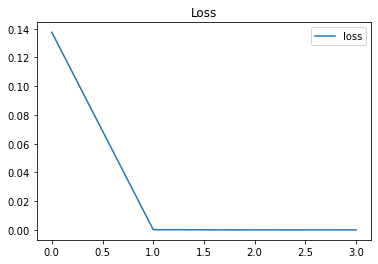

In [11]:
pd.DataFrame(history.history)[['loss']].plot()
plt.title("Loss")
plt.show()

# 4. Visualize the result

In [12]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [13]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 100.00%


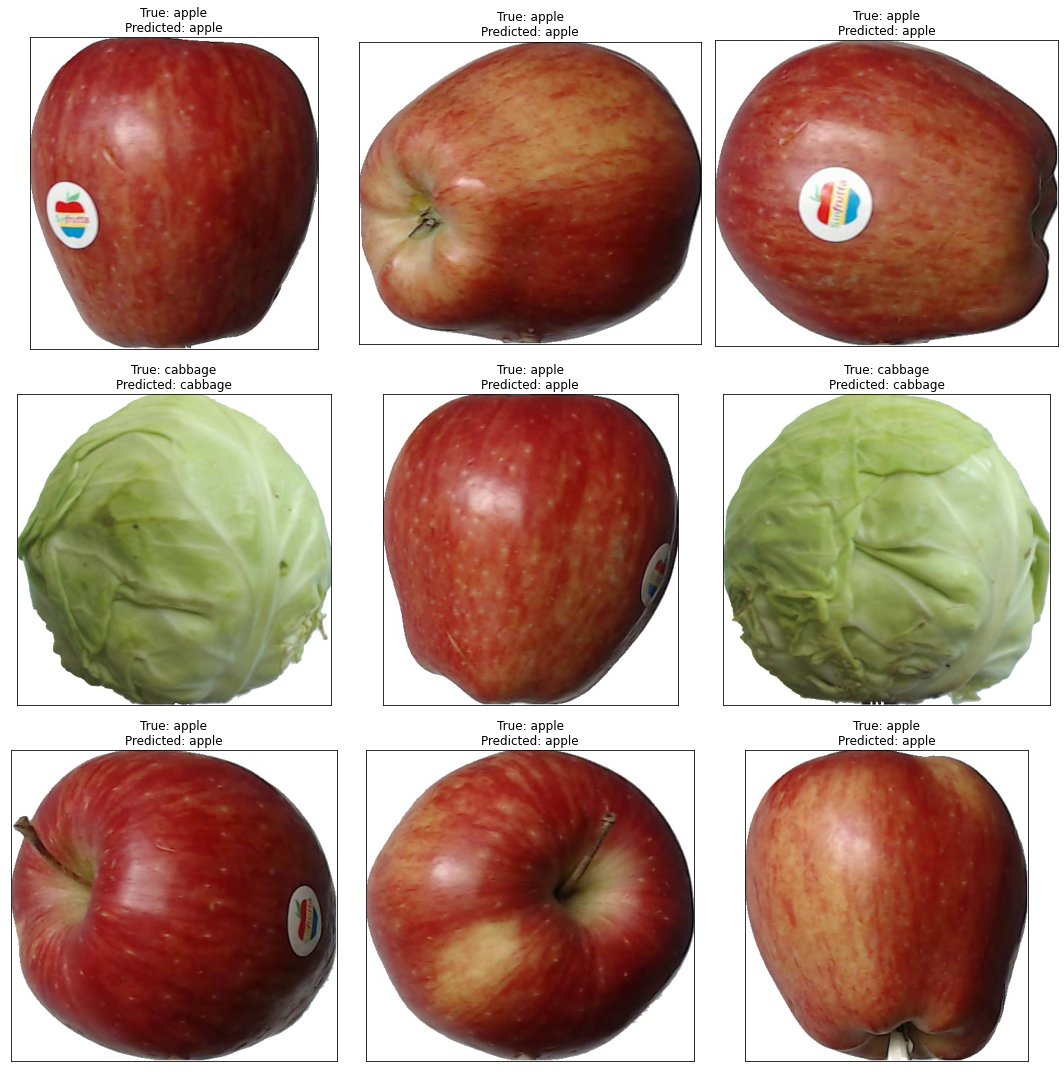

In [14]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()